The first notebook has a bit too much going on and not enough commentary, let's clean it up and start working from there :)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pydicom
from fastai2.vision.all import *
from nbdev.showdoc import *
from fastai2.medical.imaging import *
import seaborn as sns
from IPython.display import Image
from skimage import measure
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.figure_factory as FF
from plotly.graph_objs import *
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

First lets set up for file management variables and some easier paths to be accessing from.

The dicoms for training and testing are broken up into folders -- each has it's own csv as well

In [2]:
path = Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic')
path.ls()

(#6) [Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic/test.csv'),Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic/train'),Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic/train.csv'),Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic/test'),Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic/osic-pulmonary-fibrosis-progression.zip'),Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic/sample_submission.csv')]

In [3]:
Path.BASE_PATH = path
path.ls()

(#6) [Path('test.csv'),Path('train'),Path('train.csv'),Path('test'),Path('osic-pulmonary-fibrosis-progression.zip'),Path('sample_submission.csv')]

In [4]:
train_path = path/'train'
test_path = path/'test'
train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')
sample_sub = pd.read_csv(path/'sample_submission.csv')

In [5]:
train_df.shape, test_df.shape, sample_sub.shape

((1549, 7), (5, 7), (730, 3))

Hmm interesting - only 5 rows in the test csv but 730 required in submission file(!) - the number of patients in test matches the test df. For train, you see 176 patients but 1,549 measurements.

In [6]:
len(train_path.ls()), len(test_path.ls())

(176, 5)

Quickly examine the heads of all the csvs

In [7]:
#some nice tabular data to add to dicom info
train_df.head(1)

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker


In [8]:
#same info as train
test_df.head(1)

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker


In [9]:
#we need to predict FCV and the confidence for a particular wk
sample_sub.head(1)

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2000,100


As mentioned, there are 176 patients but 1,549 measurements in the training csv -- what's up with that? Is there a gross distribution that we'll need to be mindful of? Meaning, do a few patients have 100's of measurements while the remaining only have 1 or 2?

In [10]:
train_df['Patient'].value_counts()

ID00421637202311550012437    10
ID00105637202208831864134    10
ID00140637202231728595149    10
ID00167637202237397919352    10
ID00119637202215426335765    10
                             ..
ID00344637202287684217717     7
ID00186637202242472088675     7
ID00111637202210956877205     7
ID00267637202270790561585     6
ID00047637202184938901501     6
Name: Patient, Length: 176, dtype: int64

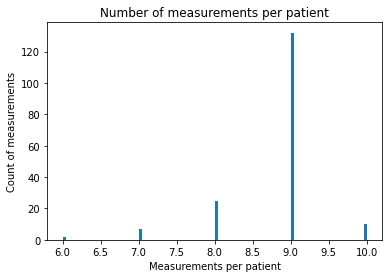

In [11]:
#ok so not too bad - most patients have 9 measurements
plt.hist(train_df['Patient'].value_counts(), bins=100)
plt.title('Number of measurements per patient')
plt.xlabel('Measurements per patient')
plt.ylabel('Count of measurements');

We know from the competition description that we'll need to be providing FVC/confidence values for multiple measurements (different time points). Be mindful of the fact that some of the week information in train_df doens't make sense (which seems to have been done intentionally)

In [12]:
train_df['Weeks'].value_counts()

 8     45
 12    44
 18    42
 10    41
 6     40
       ..
 95     1
 93     1
 91     1
 88     1
-2      1
Name: Weeks, Length: 112, dtype: int64

In [13]:
min(train_df['Weeks'])

-5

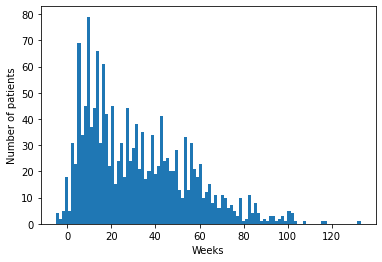

In [14]:
plt.hist(train_df['Weeks'], bins=100)
plt.xlabel('Weeks')
plt.ylabel('Number of patients');

Ok so some patients are measured over 40 weeks out - but also there are some patients with negative week values(!) The line below will show the proportion of this. This is mentioned in the competition description

In [15]:
(train_df['Weeks'] < 0).value_counts()

False    1538
True       11
Name: Weeks, dtype: int64

In [16]:
#let's index into the df to see just those with negatives
train_df[train_df['Weeks'] < 0]

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
80,ID00023637202179104603099,-3,1536,65.306122,71,Female,Ex-smoker
175,ID00051637202185848464638,-1,1697,81.645417,73,Female,Ex-smoker
261,ID00076637202199015035026,-4,2298,52.749977,51,Male,Never smoked
297,ID00086637202203494931510,-5,3367,117.628563,65,Female,Never smoked
323,ID00093637202205278167493,-1,3695,84.958153,69,Male,Ex-smoker
438,ID00122637202216437668965,-4,2581,69.501293,58,Male,Ex-smoker
534,ID00133637202223847701934,-2,3195,92.856312,83,Male,Never smoked
840,ID00222637202259066229764,-1,2644,62.832700,70,Male,Ex-smoker
894,ID00233637202260580149633,-3,3829,100.784376,68,Male,Ex-smoker


Ok so no patient looks to have multiple negative measurements

Does each patient have the same number of dicoms? This can be simply gleaned from taking the number of dcms per folder.

We'll use a list comprehension to walk down the training path and examine the number of dcms per patient -- storing that value into the counts list. Fast.Ai's awesome convenience fxns that sit on top of normal python Pathlib fxns make this extraction possible with just that one line of code!

In [17]:
counts = [len(patients.ls()) for patients in train_path.ls() ]
len(counts), min(counts), max(counts) #1018? yikes

(176, 12, 1018)

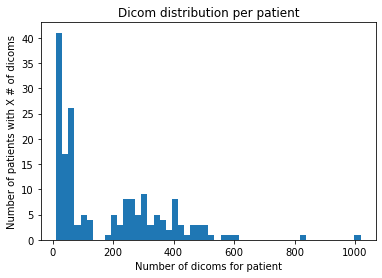

In [18]:
#most patients in the lower end of this
#some with multiple hundred???
plt.hist(counts, bins=50);
plt.xlabel('Number of dicoms for patient')
plt.ylabel('Number of patients with X # of dicoms')
plt.title('Dicom distribution per patient');

We'll be using a rescale slope/intercept later on to try to turn the scans into a more tenable format for our models. But  some scans have hundreds of slices while others only have a few -- the pixel spacing & slice thickness values vary between scanner, but this magnatude of difference in number of slices is also probably attributable to the fact that some scans take into account a larger area

Before diving into the dicoms - let's quickly try to glean some more info from the dfs

In [19]:
fem = (train_df['Sex'] == 'Female').sum()
male = len(train_df) - fem
print("There are {} females and {} males".format(fem, male))

There are 325 females and 1224 males


In [20]:
#ok so pretty big skew towards males
percent_female = fem/len(train_df) * 100
print(f"Only {percent_female:.2f}% of the dataset is female!!")

Only 20.98% of the dataset is female!!


Is this skew bc the disease is more prevalent for Men or because the sampling is skewed?

In [21]:
train_df['SmokingStatus'].value_counts()

Ex-smoker           1038
Never smoked         429
Currently smokes      82
Name: SmokingStatus, dtype: int64

In [22]:
ex_smoker = train_df['SmokingStatus'].value_counts()['Ex-smoker']
ex_smoker_perc = ex_smoker/len(train_df) * 100
smoker = train_df['SmokingStatus'].value_counts()['Currently smokes']
smoker_perc = smoker / len(train_df)*100
never_smoke = train_df['SmokingStatus'].value_counts()['Never smoked']
never_smoke_perc = never_smoke / len(train_df)*100

In [23]:
print(f'{ex_smoker_perc:.2f}% of measurements are of ex-smokers')
print(f'{smoker_perc:.2f}% of measurements are of current smokers')
print(f'{never_smoke_perc:.2f}% of measurements are of those who never smoked')

67.01% of measurements are of ex-smokers
5.29% of measurements are of current smokers
27.70% of measurements are of those who never smoked


~72 of the FVC measurements are of people who previously smoked or currently do

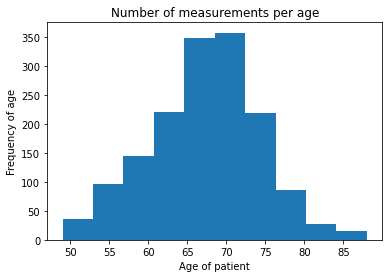

In [24]:
plt.hist(train_df['Age'])
plt.xlabel("Age of patient")
plt.ylabel("Frequency of age")
plt.title('Number of measurements per age');

FVC check

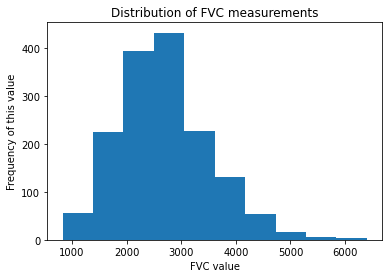

In [25]:
plt.hist(train_df['FVC'])
plt.xlabel('FVC value')
plt.ylabel('Frequency of this value')
plt.title('Distribution of FVC measurements');

There is most certainly some statistical correlation between the age of the patient, their gender and smoking status in relation to the FVC measurements. At this point we could determine that relationship and then try to develop a model based on these meta features.

But that's probably already been exhaustively explored, why else are we going through the effort of trying to develop a solution through the use of imaging?

Should circle back around and create some visualization that would elucidate this later -- really just itching to dive into the dicoms right now though. 

While the best solution will most likely create a vision model and then feed the output of that into a normal fully connected network that takes into account this metadata from the csv -- that's for another day!

In [26]:
#choosing two patients (second one chosen intentionally)
patient_1 = train_path.ls()[100]
patient_2 = (train_path/'ID00232637202260377586117')
len(patient_1.ls()), len(patient_2.ls())

(36, 67)

In [27]:
patient_1_slice = patient_1.ls()[0]
patient_2_slice = patient_2.ls()[0]
patient_1_slice, patient_2_slice

(Path('train/ID00408637202308839708961/18.dcm'),
 Path('train/ID00232637202260377586117/18.dcm'))

In [28]:
dcmread(patient_1_slice)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.158180224579486107106172137277788130663
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.1
(0002, 0013) Implementation Version Name         SH: 'OSIRIX_361'
(0002, 0016) Source Application Entity Title     AE: 'ANONYMOUS'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0018) SOP Instance UID                    UI: 2.25.158180224579486107106172137277788130663
(0008, 0060) Modality                            CS: 'CT'
(0008, 0070) Manufacturer                        LO: 'SIEMENS'

A whole lot of info in one file! 

The following resource helps interpret some of it: http://dicom.nema.org/medical/dicom/2017d/output/chtml/part03/sect_C.7.6.2.html

(0020, 0013) Instance Number --> IS: "18"
Corresponds to the fact that this is the 18th dicom for this patient (are they ordered in a spatial way?)

These two determine **voxel size**:


**(0018, 0050) Slice Thickness --> DS: "5.0"
this is expressed in millimeters** --> z-axis

**(0028, 0030) Pixel Spacing --> DS: [0.683, 0.683]
physical distance between center of each pixel. The pair of values indicates adjacent row spacing and adjacent column spacing** --> x/y plane

(0020, 1041) Slice Location --> DS: "82.0"
relative position of the image plane expressed in millimeters

(0020, 0032) Image Position (Patient) --> DS: [-174.2187, -175.0000, 1773.500] tells the x,y,z coordinates of the upper left hand corner (center of the firxt voxel transmitted) of image in millimeters

We will also take into account the Rescale slope & intercept below in order to convert the pixel values into the Hounsfield scale: https://en.wikipedia.org/wiki/Hounsfield_scale

In [29]:
dcmread(patient_1_slice).PixelData[0:20]

b'H\x00\x1d\x00\x15\x00\x00\x000\x00\x00\x00\x0e\x00*\x00\x1c\x00,\x00'

The pixel information is stored in hex -- we could try to do the conversion ourselves but that sounds cumbersome. Luckily we can just access the information with "pixel_array"

In [30]:
pat_1_dcm = dcmread(patient_1_slice)
pat_1_dcm.pixel_array

array([[72, 29, 21, ...,  0,  0,  0],
       [ 0, 14, 25, ...,  0,  0,  0],
       [27,  0, 21, ...,  0,  0,  0],
       ...,
       [ 0, 74,  0, ...,  0,  0,  0],
       [ 0, 77, 24, ...,  0,  0,  0],
       [23,  0,  8, ...,  0,  0,  0]], dtype=uint16)

A quick but important digression, if you look at some of the pixel information for certain patients (like the second one chosen) you'll see some funky values initially (this was done in the previous notebook) 

All those initial values of -2048(!) This will be further explored during our conversion to the hounsfield scale

In [31]:
pat_2_dcm = dcmread(patient_2_slice)
pat_2_dcm.pixel_array

array([[-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       ...,
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048]], dtype=int16)

In [32]:
#ok so 512 by 512 pixel slices
pat_1_dcm.pixel_array.shape, pat_2_dcm.pixel_array.shape

((512, 512), (512, 512))

We'll take a look at the patients FVC measurements as well and see if we can glean anything from this ONE slice of the CT scan

In [33]:
train_df[train_df['Patient'] == patient_1.name]

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
1469,ID00408637202308839708961,13,2651,97.405938,74,Male,Ex-smoker
1470,ID00408637202308839708961,14,2377,87.338330,74,Male,Ex-smoker
1471,ID00408637202308839708961,16,2414,88.697825,74,Male,Ex-smoker
1472,ID00408637202308839708961,18,2384,87.595532,74,Male,Ex-smoker
1473,ID00408637202308839708961,20,2181,80.136684,74,Male,Ex-smoker
1474,ID00408637202308839708961,26,2374,87.228101,74,Male,Ex-smoker
1475,ID00408637202308839708961,37,2504,92.004703,74,Male,Ex-smoker
1476,ID00408637202308839708961,50,2416,88.771311,74,Male,Ex-smoker


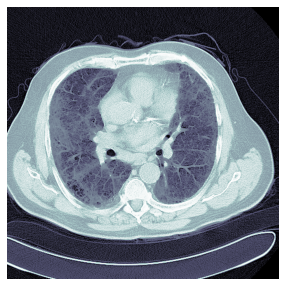

In [34]:
pat_1_dcm.show()

In [35]:
train_df[train_df['Patient'] == patient_2.name]

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
885,ID00232637202260377586117,9,1909,115.431128,74,Female,Never smoked
886,ID00232637202260377586117,11,1977,119.542871,74,Female,Never smoked
887,ID00232637202260377586117,13,2095,126.677954,74,Female,Never smoked
888,ID00232637202260377586117,15,1841,111.319386,74,Female,Never smoked
889,ID00232637202260377586117,17,1803,109.021647,74,Female,Never smoked
890,ID00232637202260377586117,23,1732,104.728504,74,Female,Never smoked
891,ID00232637202260377586117,35,2095,126.677954,74,Female,Never smoked
892,ID00232637202260377586117,47,1813,109.626315,74,Female,Never smoked
893,ID00232637202260377586117,63,1845,111.561253,74,Female,Never smoked


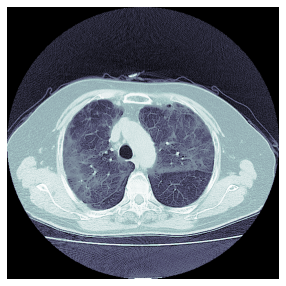

In [36]:
pat_2_dcm.show()

Fastai's show method makes it easy to view a dicom :)

Considering these two patients FVC and metadata informaion. Both are the same age, but the first is a male and was a smoker

The percent field indicates: "a computed field which approximates the patient's FVC as a percent of the typical FVC for a person of similar characteristics"

So while patient #2 has a smaller FVC - she is crushing the rest of her peers with similar characteristics. The lower FVC can be explained by a discrepency of size. A male that is 6" taller than a female will most likely have a bigger lung capacity. In terms of how the scans look, patient #2's scan is making me less uncomfortable bc it doesn't have that huge mass in the middle

Did you notice another difference between the two scans??

Aside from the fact that both lungs really different(!) you can also see a very clear circular boundary around the second scan(!) This explains those -2000 values when we saw the pixel array. What gives?

If you reference the hounsfield scale (https://en.wikipedia.org/wiki/Hounsfield_scale) you'll notice that the air only goes to -1000. As explained by Dr. Chen: these low values represent the voxels that are outside of the bore of the CT. An issue of this is that bc Air has a higher value - it appears grey (as opposed to being black) and this reduces the contrast of the lungs and soft tissue that we hope to examine! 

https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/

^Alot of the visualizations that we'll explore are from Dr. Chens amazing tutorial! Since it is over 3 years old, we'll have to modify some things. Another great refernece notebook that many people in this competition are using is that of Guido Zuidhof (https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial). We'll come to his work for the segmentation portion however

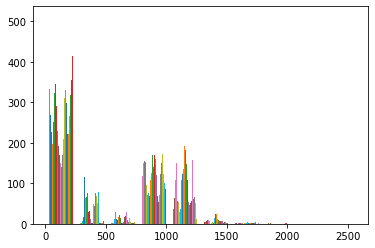

In [37]:
plt.hist(pat_1_dcm.pixel_array);

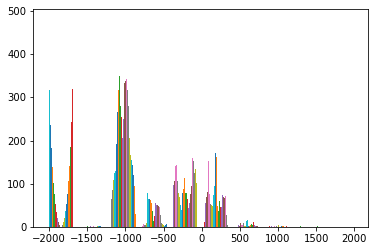

In [38]:
plt.hist(pat_2_dcm.pixel_array);

So we can see that the slice with the border (patient #2) has a differnt pixel distribution! We will work on rectifying this in a bit through resampling! 

Before we get to that, let's take a peek at the metadata distribution across patients and see if anything striking comes to the fore -- we'll make the assumption that for each patient, one scan will have the same information as all the other scans in that folder. The discrepency should not be seen inside a specific scan of a patient but between different patients!

In [39]:
#can access item in a dicom with:
PS = dcmread(patient_1.ls()[0]).PixelSpacing
PS, type(PS)

([0.724609375, 0.724609375], pydicom.multival.MultiValue)

This has a (weird) type associated with dicoms -- this is something to be mindful of when resampling. Converting between types could lead to information loss or distortion which could explain why I had so much trouble with the segmentation visualizations in the first pass

Each scan has it's own slice thickness & pixel spacing, which helps explain the discrepency in the number of dicoms per patient

In [40]:
slice_thick = []
pixel_spacing = []
rescale_slope = []
rescale_intercept = []
rows, columns = [], []

This will walk down all the folders, each which has it's own scan, it will pull the first slice in each folder and then extract the values for all items initialized above (we know that the x & y items in PixelSpacing are the same for all scans, so I won't create a fxn to check that)

In [41]:
for x in train_path.ls():
    dcm = dcmread(x.ls()[0]) #dcm of one slice
    pixel_spacing.append(float(dcm.PixelSpacing[0]))
    slice_thick.append(float(dcm.SliceThickness))
    rescale_intercept.append(float(dcm.RescaleIntercept))
    rescale_slope.append(float(dcm.RescaleSlope))
    rows.append(float(dcm.Rows))
    columns.append(float(dcm.Columns))

In [42]:
patient_id = [x.name for x in train_path.ls()]
scan_values = pd.DataFrame(data=patient_id, columns=['patient'])
scan_values['slice_thickness'] = slice_thick
scan_values['pixel_spacing'] = pixel_spacing
scan_values['n_rows'] = rows
scan_values['n_columns'] = columns
scan_values['rescale_intercept'] = rescale_intercept
scan_values['rescale_slope'] = rescale_slope

In [43]:
#this will let us identify which scans to look @ for topics
scan_values

,patient,slice_thickness,pixel_spacing,n_rows,n_columns,rescale_intercept,rescale_slope
0,ID00232637202260377586117,5.000,0.683000,512.0,512.0,0.0,1.0
1,ID00134637202223873059688,1.000,0.740234,512.0,512.0,-1024.0,1.0
2,ID00093637202205278167493,1.000,0.880859,512.0,512.0,-1024.0,1.0
3,ID00307637202282126172865,1.000,0.707031,512.0,512.0,-1024.0,1.0
4,ID00364637202296074419422,1.000,0.712891,512.0,512.0,-1024.0,1.0
...,...,...,...,...,...,...,...
171,ID00336637202286801879145,1.000,0.650391,512.0,512.0,-1024.0,1.0
172,ID00383637202300493233675,1.000,0.656250,512.0,512.0,-1024.0,1.0
173,ID00067637202189903532242,1.250,0.871094,733.0,888.0,0.0,1.0
174,ID00317637202283194142136,0.625,0.677734,512.0,512.0,-1024.0,1.0


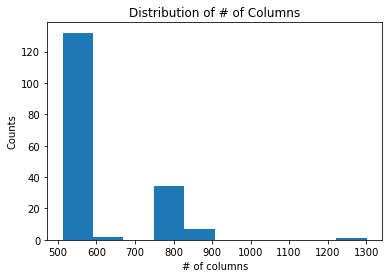

In [44]:
plt.title('Distribution of # of Columns')
plt.xlabel('# of columns')
plt.ylabel('Counts')
plt.hist(columns);

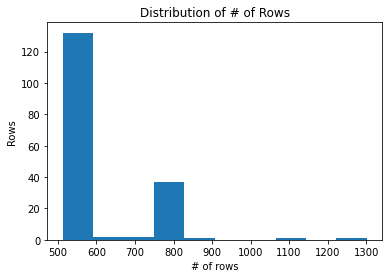

In [45]:
plt.title('Distribution of # of Rows')
plt.xlabel('# of rows')
plt.ylabel('Rows')
plt.hist(rows);

Ok so some images are clearly NOT 512x512. A discrepency in the area of the image can help explain some of the discrepencies seen in the number of slices

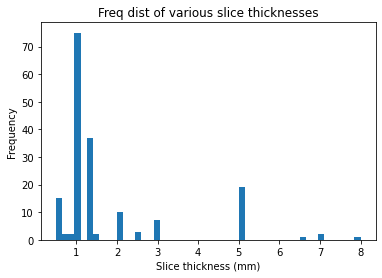

In [46]:
plt.xlabel('Slice thickness (mm)')
plt.ylabel('Frequency')
plt.title('Freq dist of various slice thicknesses')
plt.hist(slice_thick, bins=50);

In [47]:
max(slice_thick), min(slice_thick)

(8.0, 0.5)

Oh.... Some slices are 16+ times thicker than others.

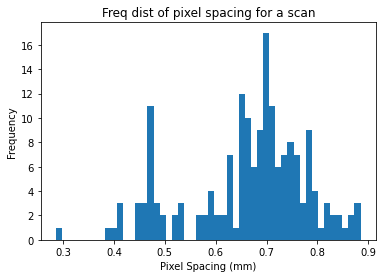

In [48]:
plt.xlabel('Pixel Spacing (mm)')
plt.ylabel('Frequency')
plt.title('Freq dist of pixel spacing for a scan')
plt.hist(pixel_spacing, bins=50);

In [49]:
#ok a 4 fold increase between smallest and biggest
min(pixel_spacing), max(pixel_spacing)

(0.286313, 0.884766)

Let's look at the area & volume that

In [50]:
#can index in pandas quite conveniently :)
scan_values.pixel_spacing

0      0.683000
1      0.740234
2      0.880859
3      0.707031
4      0.712891
         ...   
171    0.650391
172    0.656250
173    0.871094
174    0.677734
175    0.665000
Name: pixel_spacing, Length: 176, dtype: float64

In [51]:
#we know pixel_spacing same in both dimensions
scan_values['row_distance'] = scan_values.n_rows * scan_values.pixel_spacing
scan_values['column_distance'] = scan_values.n_columns * scan_values.pixel_spacing
#now we can compute the area (mm2) and volume (mm3)
scan_values['area'] = (scan_values.row_distance * scan_values.column_distance)*0.1
#slice thickness is the depth dimension
scan_values['volume'] = (scan_values.slice_thickness * scan_values.area)*0.1

Text(0.5, 1.0, 'Distribution of scan slice volume (cm**3)')

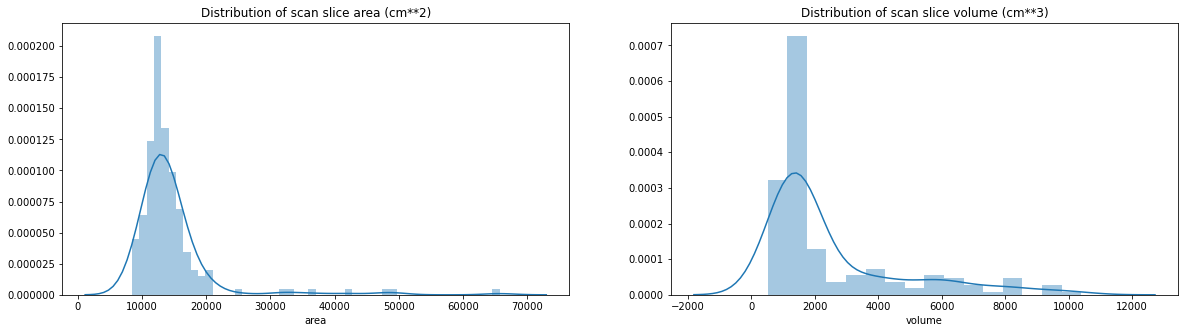

In [52]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.distplot(scan_values.area, ax=ax[0])
sns.distplot(scan_values.volume, ax=ax[1])
ax[0].set_title('Distribution of scan slice area (cm**2)')
ax[1].set_title('Distribution of scan slice volume (cm**3)')

Ok we can see that some images have a way bigger area/volume (voxel size) than others

Let's also look at the rescale slope & intercept

In [53]:
#Cast to pandas object and then confirm slope is same for all
pd.Series(rescale_slope).value_counts()

1.0    176
dtype: int64

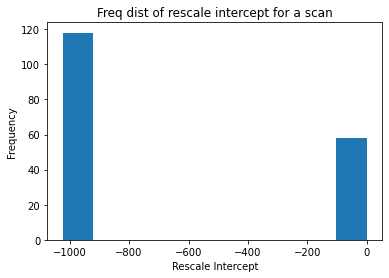

In [54]:
plt.xlabel('Rescale Intercept')
plt.ylabel('Frequency')
plt.title('Freq dist of rescale intercept for a scan')
plt.hist(rescale_intercept);

In [55]:
pd.Series(rescale_intercept).value_counts()

-1024.0    117
 0.0        58
-1000.0      1
dtype: int64

This rescale intercept will play a role in our conversion to the hounsfield scale. Since all the slopes are 1, we don't really need to do anything with that. We presumably can skip that computation or at the very least skip the lookup into a dicom to retrieve that value

Enough EDA for the time being. Let's direct our attenton towards  the elephant in the room -- the images themselves.

We don't want to keep referencing the dicoms in memory in order to visualize, transform and revisualize. So let's create a function that will extract the dicoms (in the correct order)  so that we can stack them into an array for the patient. This array will preserve the information of the dicom initially but we'll mainly want to pull out the pixel information which we can then keep in a numpy array or pytorch tensor

We will also use this later on when we try to process the entire dataset and then save for use in our modeling!

In [56]:
patient_1.ls()[0].name, dcmread(patient_1.ls()[0]).InstanceNumber

('18.dcm', "18")

The above just shows that the title of dicom file corresponds to the instance number inside the dicom. The instance number helps orient the order we want to visualize, process and interpret the scans

In [57]:
def dcm_sort(patient_folder):
    #list comprehension that runs through folder of dicoms
    dcm_stacked = [dcmread(dcm) for dcm in patient_folder.ls()]
    dcm_stacked.sort(key=lambda x: int(x.InstanceNumber))
    #returning a python list of dicoms sorted
    return dcm_stacked

Tried use dcm_stacked in above fxn for the return by doing the sort in the return fxn - it did not work for some reason. And it must be done before the return
I guess that makes sense - sorting is somewhat memory intensive and it's not like you're just doing a simple computation on a return value (or set of return values)

In [58]:
#to confirm that output in ascending order
sortz = dcm_sort(patient_1)
sortz[0].InstanceNumber, sortz[1].InstanceNumber, sortz[35].InstanceNumber

("1", "2", "36")

In [59]:
type(sortz)

list

In [60]:
#patient 1 didn't have the border so let's progress with #2
sorted_dcm = dcm_sort(patient_2)
len(sorted_dcm)

67

In [61]:
#Just to show all the black pixels on the borders
sorted_dcm[0].pixel_array

array([[-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       ...,
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048]], dtype=int16)

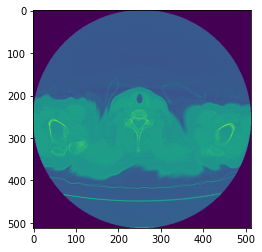

In [62]:
plt.imshow(sorted_dcm[0].pixel_array);

That doesn't look like a lung as we were hoping for. Why? Presumably because as you approach the top and bottom of the scan, you are no longer looking at the lung cavity itself but perhaps the boundary point or beyond. Let's take a look at a scan in the middle!

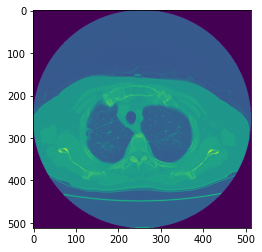

In [63]:
one_slice = sorted_dcm[12].pixel_array
plt.imshow(one_slice); #much better!

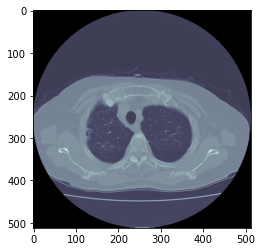

In [64]:
#try out different color maps -- bone seems to be standard
#color map is not changing the underlying pixel information
#plt.imshow(one_slice, cmap='spring');
plt.imshow(one_slice, cmap='bone');

In [65]:
pd.Series(one_slice.flatten()).value_counts()[0:10]

-2048    56252
-1007      721
-1024      716
-1011      704
-1009      703
-1022      702
-1019      691
-999       688
-1008      683
-995       679
dtype: int64

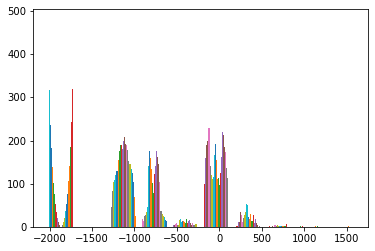

In [66]:
#Let's take a look at a histogram for this patient
plt.hist(one_slice);

Example below shows cool indexing to manipulate pixels on the whole if they meet some condition

In [67]:
small = one_slice[0:3, 0:3]
small

array([[-2048, -2048, -2048],
       [-2048, -2048, -2048],
       [-2048, -2048, -2048]], dtype=int16)

In [68]:
small[small <= -1000] = 0
small

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=int16)

Using that - let's create a function that lets you choose a threshold value and then replace all the pixels that are at or below said value. 

-1000 represents air in the hounsfield scale and 0 represents water

Rather than doing it on a single slice, let's operate over all of the slices for a patient at once

In [69]:
def ct_transformed_hu(dcm_sorted, threshold=-1000, replace=-1000):
    intercept = dcm_sorted[0].RescaleIntercept
    slices_stacked = np.stack([dcm.pixel_array for dcm in dcm_sorted])
    slices_stacked = slices_stacked.astype(float)
    
    #converts the unknown values to desired replacement
    slices_stacked[slices_stacked <= threshold] = replace
    
    #turn into hounsfield scale
    slices_stacked += np.int16(intercept)
    
    return np.array(slices_stacked, dtype=np.int16)

In [70]:
hu_ct = ct_transformed_hu(sorted_dcm, replace=-0)

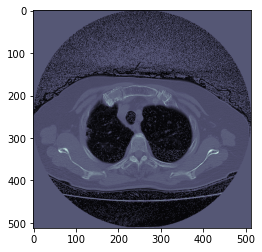

In [71]:
#that's not what we wanted..... the border is just grey now
plt.imshow(hu_ct[12], cmap='bone');

In [72]:
#this is bc the rescale intercept is zero for this scan
#chose -1000 for the replace value-- want it to look like air
hu_ct = ct_transformed_hu(sorted_dcm, threshold=-1000, 
                         replace=-1000)

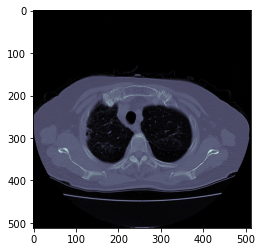

In [73]:
#nice! now the border is gone
plt.imshow(hu_ct[12], cmap='bone');

The resampling shown below is also from Dr. Chen

We want to utilize the slice thickness & pixel spacing information in order to resample each slice to 1x1x1mm pixels so we can be able to compare and display the scans in 3D 

In [74]:
def resample(slices, dcms, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([dcms[0].SliceThickness] + [dcms[0].PixelSpacing[0],
                                                dcms[1].PixelSpacing[1]]))
    spacing = np.array(list(spacing), dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = slices.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / slices.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(slices, 
                                real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [75]:
resampled_img, new_spacing = resample(hu_ct, sorted_dcm)

In [76]:
print('Shape before resampling: ', hu_ct.shape)
print('Shape after resampling: ', resampled_img.shape)

Shape before resampling:  (67, 512, 512)
Shape after resampling:  (335, 350, 350)


In [77]:
new_spacing

array([1.        , 0.99913147, 0.99913147])

For some reason the 3D viz with plotly renders better - so we'll look at that first

In [78]:
def make_mesh(image, threshold=-300, step_size=1):

    print("Transposing surface")
    p = image.transpose(2,1,0)
    print("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes(p, 
                threshold, step_size=step_size, 
                method='lewiner', allow_degenerate=True) 
    return verts, faces

In [79]:
#??measure.marching_cubes

In [80]:
def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print("Drawing")
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

In [81]:
#measure.marching_cubes(resampled_img.transpose(2,1,0), -300)

In [82]:
#this 3d visualization makes the file too big for github
#verts, faces = make_mesh(hu_ct, 450, 1.5)
#plotly_3d(verts, faces)

In Dr. Chens tutorial he does this 3D viz with the resampled image -- but this keeps throwing an error. Had to use the original pixels converted to HU. It's crashing out during marching cubes fxn for some reason(!) Since this is just a visualization and not a manipulation of the data that we need -- won't get hung up on some of the issues seen at first glance like the weird plate behind the ribcage

In [83]:
def plt_3d(verts, faces):
    print("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    mesh.set_facecolor('b')
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    plt.show()

Transposing surface
Calculating surface
Drawing


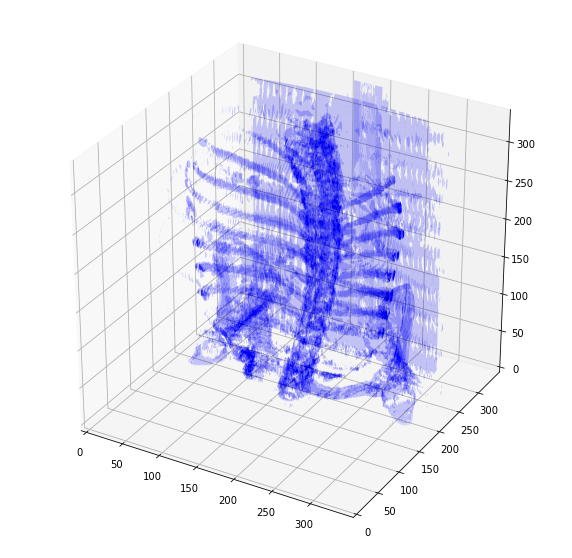

In [84]:
verts, faces = make_mesh(resampled_img, 350, 1)
plt_3d(verts, faces)

This is def upside down.

Let's try to do the visualizations on the smallest and largest scans by volume and see if there's any difference

In [99]:
min_vol = scan_values[scan_values['volume'] == scan_values.volume.min()]['patient'].item()
max_vol = scan_values[scan_values['volume'] == scan_values.volume.max()]['patient'].item()

In [101]:
max_vol, min_vol

('ID00264637202270643353440', 'ID00020637202178344345685')

In [102]:
??dcm_sort

In [107]:
(train_path/max_vol).ls()

(#61) [Path('train/ID00264637202270643353440/18.dcm'),Path('train/ID00264637202270643353440/10.dcm'),Path('train/ID00264637202270643353440/29.dcm'),Path('train/ID00264637202270643353440/14.dcm'),Path('train/ID00264637202270643353440/24.dcm'),Path('train/ID00264637202270643353440/32.dcm'),Path('train/ID00264637202270643353440/51.dcm'),Path('train/ID00264637202270643353440/2.dcm'),Path('train/ID00264637202270643353440/48.dcm'),Path('train/ID00264637202270643353440/59.dcm')...]

In [109]:
max_sorted = dcm_sort(train_path/max_vol)
min_sorted = dcm_sort(train_path/min_vol)

In [112]:
len(max_sorted), len(min_sorted)

(61, 493)

The scan with the smallest volume has 493 slices??????????

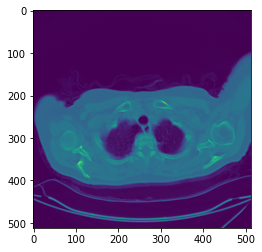

In [116]:
plt.imshow(max_sorted[10].pixel_array);

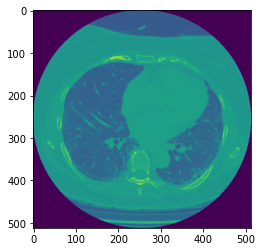

In [121]:
plt.imshow(min_sorted[250].pixel_array);

In [123]:
max_hu = ct_transformed_hu(max_sorted, replace=0)
min_hu = ct_transformed_hu(min_sorted, replace=0)

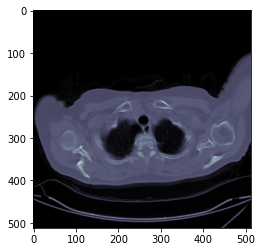

In [126]:
plt.imshow(max_hu[10], cmap='bone');

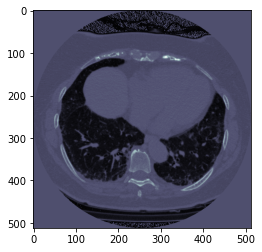

In [128]:
plt.imshow(min_hu[200], cmap='bone');

In [129]:
max_resampled, new_max_spacing = resample(max_hu, max_sorted)
min_resampled, new_min_spacing = resample(max_hu, min_sorted)

In [133]:
print('Max vol shape before resampling: ', max_hu.shape)
print('Max vol shape after resampling: ', max_resampled.shape)
print('the new spacing is:', new_max_spacing)

Max vol shape before resampling:  (61, 512, 512)
Max vol shape after resampling:  (396, 400, 400)
the new spacing is: [1.00126263 1.         1.        ]


In [134]:
print('Min vol shape before resampling: ', min_hu.shape)
print('Min vol shape after resampling: ', min_resampled.shape)
print('The new spacing is:', new_min_spacing)

Min vol shape before resampling:  (493, 512, 512)
Min vol shape after resampling:  (30, 320, 320)
The new spacing is: [1.01666667 1.         1.        ]


So the one with 493 slices is now only 30.....

In [137]:
max_sorted[0].SliceThickness, max_sorted[0].PixelSpacing

("6.5", [0.78125, 0.78125])

In [138]:
min_sorted[0].SliceThickness, min_sorted[0].PixelSpacing

("0.5", [0.625, 0.625])

And the voxel values help explain this discrepency!
The x/y plane of pixel spacing is multiplied by slice thickness (z-axis) to see that the max volume scan is huge dur to both it's slice thickness being an order of magnitude bigger but also bc the pixel spacing is bigger

In [142]:
min_sorted[0].Manufacturer, min_sorted[0].ManufacturerModelName

('TOSHIBA', 'Aquilion')

In [143]:
max_sorted[0].Manufacturer, max_sorted[0].ManufacturerModelName

('Philips', 'Mx8000 Dual')

This paper outlines the impact of using different scanners: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5462462/

Transposing surface
Calculating surface
Drawing


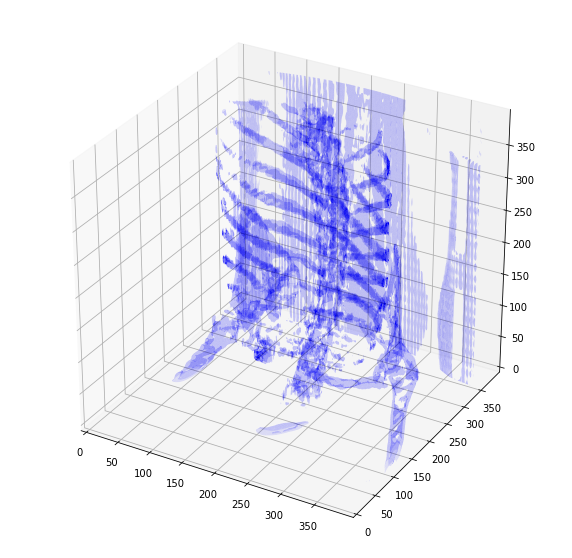

In [150]:
### let's take a look at the maximum volume scan first
verts, faces = make_mesh(max_resampled, 350, 1)
plt_3d(verts, faces)

Transposing surface
Calculating surface
Drawing


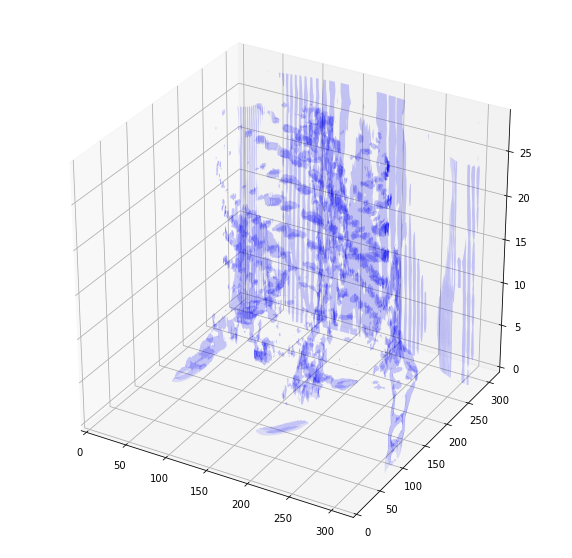

In [151]:
#let's take a look at the maximum volume scan first
verts, faces = make_mesh(min_resampled, 350, 1)
plt_3d(verts, faces)

Neither looks much better?